# Scikit-Learn and Keras Cheat Sheet

In [1]:
import numpy as np
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef, make_scorer

from tensorflow.keras import models, layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

from scikeras.wrappers import KerasClassifier

2023-12-22 16:32:18.357721: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load the dataset

In [2]:
df = pl.read_csv('../../datasets/sample_anomaly.csv', null_values=['-'])
df.head()

user,dst_port,country,anomaly
str,i64,str,i64
"""b244d142""",443,"""United States""",1
"""1021694a""",80,"""United States""",1
"""1021694a""",80,"""United States""",1
"""1021694a""",80,"""United States""",1
"""142f88ad""",443,"""United States""",1


## Ordinal encoding

In [3]:
ord_enc = OrdinalEncoder()
sca = MinMaxScaler()

df[['user']] = sca.fit_transform(ord_enc.fit_transform(df[['user']]))
df.head()

user,dst_port,country,anomaly
f64,i64,str,i64
0.698506,443,"""United States""",1
0.065101,80,"""United States""",1
0.065101,80,"""United States""",1
0.065101,80,"""United States""",1
0.08111,443,"""United States""",1


## One-Hot Encoding

In [4]:
MAX_CAT = 5
one_hot_enc = OneHotEncoder(max_categories=MAX_CAT, sparse_output=False)

encoded_columns = one_hot_enc.fit_transform(df[['country']])

for i in range(MAX_CAT):
    df = df.with_columns(pl.lit(pl.Series(f'country_{i}', [x[i] for x in encoded_columns])))
df = df.drop('country')
df.head()

user,dst_port,anomaly,country_0,country_1,country_2,country_3,country_4
f64,i64,i64,f64,f64,f64,f64,f64
0.698506,443,1,0.0,0.0,0.0,1.0,0.0
0.065101,80,1,0.0,0.0,0.0,1.0,0.0
0.065101,80,1,0.0,0.0,0.0,1.0,0.0
0.065101,80,1,0.0,0.0,0.0,1.0,0.0
0.08111,443,1,0.0,0.0,0.0,1.0,0.0


In [5]:
MAX_CAT = 5
one_hot_enc = OneHotEncoder(max_categories=MAX_CAT, sparse_output=False)

encoded_columns = one_hot_enc.fit_transform(df[['dst_port']])

for i in range(MAX_CAT):
    df = df.with_columns(pl.lit(pl.Series(f'dst_port_{i}', [x[i] for x in encoded_columns])))
df = df.drop('dst_port')
df.head()

user,anomaly,country_0,country_1,country_2,country_3,country_4,dst_port_0,dst_port_1,dst_port_2,dst_port_3,dst_port_4
f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.698506,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
0.065101,1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
0.065101,1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
0.065101,1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
0.08111,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


## Plot Data distribution

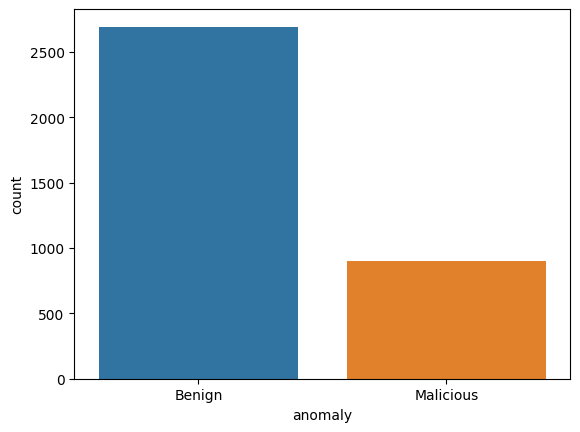

In [6]:
df_malicious = df.filter(pl.col('anomaly') == 1)
df_benign    = df.filter(pl.col('anomaly') == 0)

df_count = pl.DataFrame({'anomaly': ['Benign', 'Malicious'], 'count': [df_benign.shape[0], df_malicious.shape[0]]})
sns.barplot(x='anomaly', y='count', hue='anomaly', data=df_count)
plt.show()

## Split data from training

In [7]:
y = df['anomaly']
X = df.drop(['anomaly'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
print(f'{X.shape}')

(3592, 11)


## Train with a grid Search

### Define a method to generate DL models from Keras

In [8]:
def neural_network(optimizer='adam', activation='relu', hidden_layers=1):
  # Initialize the constructor
  model = Sequential()
  # Add an input layer
  model.add(Dense(11, activation=activation, input_shape=(11,)))

  for i in range(hidden_layers):
    # Add one hidden layer
    model.add(Dense(8, activation=activation))

  # Add an output layer 
  model.add(Dense(1, activation=activation))
  #compile model
  model.compile(loss='binary_crossentropy', optimizer=optimizer)
  return model

### Define the models and the parameters

In [9]:
models = [
    ('LR', LogisticRegression(random_state=42), {'C':[0.01, 0.1, 1.0]}),
    ('RF', RandomForestClassifier(random_state=42), {'n_estimators':[100, 150, 200],
    'min_samples_split':[2, 5, 10], 'min_samples_leaf':[1, 2, 4], 'bootstrap':[True, False]}),
    ('NN', KerasClassifier(model=neural_network, verbose=0, epochs=20, batch_size=256), {
        'model__optimizer': ['adam', 'adamax', 'rmsprop'],
        'model__activation': ['relu', 'sigmoid', 'silu'],
        'model__hidden_layers': [1,2,3]
    })
]

### Run the Grid Search and evaluate the results

Training model LR
              precision    recall  f1-score   support

      Benign       0.94      0.99      0.96       809
   Malicious       0.96      0.81      0.88       269

    accuracy                           0.94      1078
   macro avg       0.95      0.90      0.92      1078
weighted avg       0.95      0.94      0.94      1078



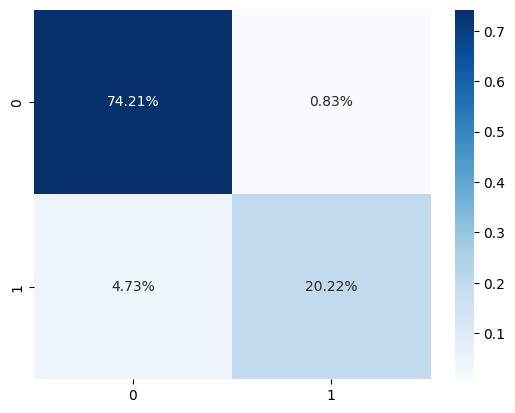

Training model RF
              precision    recall  f1-score   support

      Benign       0.99      0.99      0.99       809
   Malicious       0.96      0.97      0.96       269

    accuracy                           0.98      1078
   macro avg       0.97      0.98      0.98      1078
weighted avg       0.98      0.98      0.98      1078



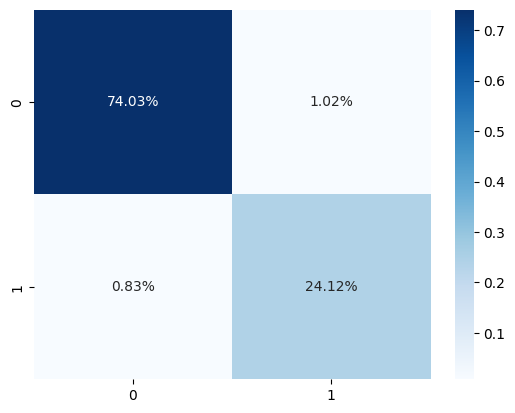

Training model NN
              precision    recall  f1-score   support

      Benign       0.75      1.00      0.86       809
   Malicious       0.00      0.00      0.00       269

    accuracy                           0.75      1078
   macro avg       0.38      0.50      0.43      1078
weighted avg       0.56      0.75      0.64      1078



/home/mantunes/git/aas/venv/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mantunes/git/aas/venv/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mantunes/git/aas/venv/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


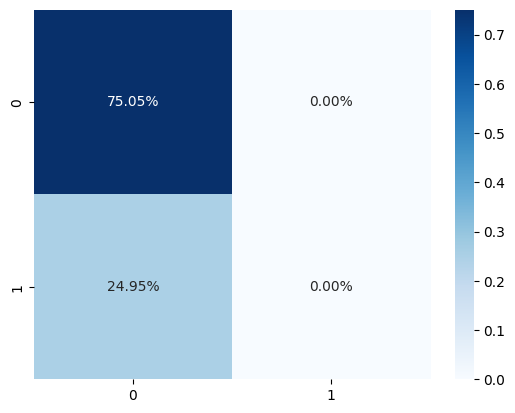

In [10]:
for n, m, p in models:
    print(f'Training model {n}')
    cla = GridSearchCV(estimator=m, param_grid=p, cv=3)
    cla.fit(X_train, y_train)
    
    y_pred = cla.predict(X_test)
    
    print(classification_report(y_test, y_pred, target_names=['Benign', 'Malicious']))
    
    cf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')
    plt.show()